# AE 598RL Final Project
Evaluation of "Shared Autonomy Through Deep Reinforcement Learning"

In [1]:
from __future__ import division
import pickle
import random
import os
import math
import types
import uuid
import time
from copy import copy
from collections import defaultdict, Counter

import numpy as np
import gym
from gym import spaces, wrappers

import dill
import tempfile
import tensorflow as tf
from tensorflow.contrib import rnn
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
import zipfile

import baselines.common.tf_util as U

from baselines import logger
from baselines.common.schedules import LinearSchedule
from baselines import deepq
from baselines.deepq.replay_buffer import ReplayBuffer, PrioritizedReplayBuffer
from baselines.deepq.simple import ActWrapper

from scipy.special import logsumexp

from pyglet.window import key as pygkey
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data_dir = os.path.join('data', 'lunarlander-sim')

## Begin function definitions

In [3]:
def disc_to_cont(action):
    if type(action) == np.ndarray:
        return action
    # main engine
    if action < 3:
        m = -throttle_mag
    elif action < 6:
        m = throttle_mag
    else:
        raise ValueError
    # steering
    if action % 3 == 0:
        s = -throttle_mag
    elif action % 3 == 1:
        s = 0
    else:
        s = throttle_mag
    return np.array([m, s])

In [4]:
def mask_helipad(obs, replace=0):
    obs = copy(obs)
    if len(obs.shape) == 1:
        obs[8] = replace
    else:
        obs[:, 8] = replace
    return obs

In [5]:
def traj_mask_helipad(traj):
    return [mask_helipad(obs) for obs in traj]

In [6]:
def onehot_encode(i, n=6):
    x = np.zeros(n)
    x[i] = 1
    return x

In [7]:
def onehot_decode(x):
    l = np.nonzero(x)[0]
    assert len(l) == 1
    return l[0]

In [8]:
def make_env(using_lander_reward_shaping=False):
    env = gym.make('LunarLanderContinuous-v2')
    env.action_space = spaces.Discrete(n_act_dim)
    env.unwrapped._step_orig = env.unwrapped._step

    def _step(self, action):
        obs, r, done, info = self._step_orig(disc_to_cont(action))
        return obs, r, done, info

    env.unwrapped._step = types.MethodType(_step, env.unwrapped)
    env.unwrapped.using_lander_reward_shaping = using_lander_reward_shaping
    return env

In [9]:
def make_q_func():
    return deepq.models.mlp([64, 64])

In [10]:
def run_ep(policy, env, max_ep_len, render=False, pilot_is_human=False):
    if pilot_is_human:
        global human_agent_action
        human_agent_action = init_human_action()
    obs = env.reset()
    done = False
    totalr = 0.
    trajectory = None
    actions = []
    for step_idx in range(max_ep_len+1):
        if done:
            trajectory = info['trajectory']
            break
        action = policy(obs[None, :])
        obs, r, done, info = env.step(action)
        actions.append(action)
        if render:
            env.render()
        totalr += r
    outcome = r if r % 100 == 0 else 0
    return totalr, outcome, trajectory, actions

In [11]:
def full_pilot_policy(obs):
    with tf.variable_scope(full_pilot_scope, reuse=None):
        return raw_full_pilot_policy._act(obs)[0]

In [12]:
def save_tf_vars(scope, path):
    sess = U.get_session()
    saver = tf.train.Saver([v for v in tf.global_variables() if v.name.startswith(scope + '/')])
    saver.save(sess, save_path=path)

In [13]:
def load_tf_vars(scope, path):
    sess = U.get_session()
    saver = tf.train.Saver([v for v in tf.global_variables() if v.name.startswith(scope + '/')])
    saver.restore(sess, path)

In [14]:
def combined_rollout(states, actions):
    return np.array([np.concatenate((
        np.array(obs),
        onehot_encode(action))) for obs, action in zip(
        states[:-1] if len(states) == len(actions) + 1 else states, actions)])

In [15]:
def format_rollouts(rollouts):
    X_dat = np.zeros((len(rollouts), max_ep_len, n_obs_dim + n_act_dim))
    Y_dat = np.zeros((len(rollouts), max_ep_len))
    M_dat = np.zeros((len(rollouts), max_ep_len))
    for i, (states, actions) in enumerate(rollouts):
        Y_dat[i, :] = states[0][-1]
        X_dat[i, :len(actions), :] = traj_mask_helipad(combined_rollout(states, actions))
        M_dat[i, :len(actions)] = 1
    return X_dat, Y_dat, M_dat

In [16]:
def next_batch(idxes, batch_size, X_dat, Y_dat, M_dat):
    batch_idxes = random.sample(idxes, batch_size)
    return X_dat[batch_idxes, :, :], Y_dat[batch_idxes, :], M_dat[batch_idxes, :]

In [17]:
def decode_goal(trajectory, gd_scope, init_state=None, only_final=False):
    traj_X = np.zeros((1, max_ep_len, n_obs_dim + n_act_dim))
    traj_X[0, :len(trajectory), :] = np.array(trajectory)
    with tf.variable_scope(gd_scope, reuse=False):
        feed_dict = {X: traj_X}
        if init_state is not None:
            feed_dict[INIT_STATE_A] = init_state[0]
            feed_dict[INIT_STATE_B] = init_state[1]
        else:
            feed_dict[INIT_STATE_A] = np.zeros((1, num_hidden))
            feed_dict[INIT_STATE_B] = np.zeros((1, num_hidden))
        if only_final:
            g, s = sess.run([predictions[len(trajectory)-1],
                             rnn_states[len(trajectory)-1]],
                             feed_dict=feed_dict
                            )
            return g[0, 0], s
        else:
            g, s = sess.run([predictions,
                             rnn_states[len(trajectory)-1]],
                             feed_dict=feed_dict
                            )
            return [x[0, 0] for x in g], s

In [18]:
def build_goal_decoder(pilot_name):
    gd_scope = '%s_gd_scope' % pilot_name
    load_tf_vars(gd_scope, os.path.join(data_dir, '%s_pilot_goal_decoder.tf' % pilot_name))
    
    init_state=None
    only_final=False
    
    traj_X = np.zeros((1, max_ep_len, n_obs_dim + n_act_dim))
    traj_X[0, :len(trajectory), :] = np.array(trajectory)
    with tf.variable_scope(gd_scope, reuse=False):
        feed_dict = {X: traj_X}
        if init_state is not None:
            feed_dict[INIT_STATE_A] = init_state[0]
            feed_dict[INIT_STATE_B] = init_state[1]
        else:
            feed_dict[INIT_STATE_A] = np.zeros((1, num_hidden))
            feed_dict[INIT_STATE_B] = np.zeros((1, num_hidden))
        if only_final:
            g, s = sess.run([predictions[len(trajectory)-1], rnn_states[len(trajectory)-1]], feed_dict=feed_dict)
            return g[0, 0], s
        else:
            g, s = sess.run([predictions, rnn_states[len(trajectory)-1]], feed_dict=feed_dict)
            return [x[0, 0] for x in g], s

In [19]:
def train_supervised_goal_decoder(pilot_name, rollouts):
    gd_scope = '%s_gd_scope' % pilot_name
    
     # make testing and validation sets
    n_val_rollouts = 100
    rollouts, val_rollouts = rollouts[:-n_val_rollouts], rollouts[-n_val_rollouts:]
    X_dat, Y_dat, M_dat = format_rollouts(rollouts)
    val_X_dat, val_Y_dat, val_M_dat = format_rollouts(val_rollouts)

    idxes = list(range(X_dat.shape[0]))

    # Training Parameters
    learning_rate = 1e-2
    training_steps = 1000
    batch_size = 128
    display_step = training_steps // 10

    # Network Parameters
    num_input = X_dat.shape[2]
    timesteps = X_dat.shape[1]
    num_hidden = 32

    with tf.variable_scope(gd_scope, reuse=False):
        # tf Graph input
        X = tf.placeholder("float", [None, timesteps, num_input])
        Y = tf.placeholder("float", [None, timesteps])
        M = tf.placeholder("float", [None, timesteps])  # mask for variable length sequences
        INIT_STATE_A = tf.placeholder("float", [None, num_hidden])
        INIT_STATE_B = tf.placeholder("float", [None, num_hidden])

        weights = {'out': tf.Variable(tf.random_normal([num_hidden, 1]))}
        biases = {'out': tf.Variable(tf.random_normal([1]))}

        unstacked_X = tf.unstack(X, timesteps, 1)

        lstm_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)

        state = (INIT_STATE_A, INIT_STATE_B)
        rnn_outputs = []
        rnn_states = []
        for input_ in unstacked_X:
            output, state = lstm_cell(input_, state)
            rnn_outputs.append(output)
            rnn_states.append(state)

        prediction = tf.reshape(
            tf.concat([tf.matmul(output, weights['out']) + biases['out'] for output in rnn_outputs], axis=1),
            shape=[tf.shape(X)[0], timesteps])

        predictions = [tf.matmul(output, weights['out']) + biases['out'] for output in rnn_outputs]

        loss_op = tf.reduce_sum((prediction - Y) ** 2 * M) / tf.reduce_sum(M)

        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss_op)

    sess = U.get_session()
    if sess is None:
        sess = U.make_session(num_cpu=4)
        sess.__enter__()

    sess.run(tf.variables_initializer([v for v in tf.global_variables() if v.name.startswith(gd_scope + '/')]))

    with tf.variable_scope(gd_scope, reuse=False):
        for step in range(1, training_steps + 1):
            batch_x, batch_y, batch_mask = next_batch(idxes, batch_size, X_dat, Y_dat, M_dat)
            sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, M: batch_mask,
                                          INIT_STATE_A: np.zeros((batch_size, num_hidden)),
                                          INIT_STATE_B: np.zeros((batch_size, num_hidden))
                                          }
                     )
            if step % display_step == 0 or step == 1:
                loss = sess.run(loss_op, feed_dict={X: X_dat,
                                                    Y: Y_dat,
                                                    M: M_dat,
                                                    INIT_STATE_A: np.zeros((X_dat.shape[0], num_hidden)),
                                                    INIT_STATE_B: np.zeros((X_dat.shape[0], num_hidden))
                                                    }
                                )
                val_loss = sess.run(loss_op, feed_dict={X: val_X_dat,
                                                        Y: val_Y_dat,
                                                        M: val_M_dat,
                                                        INIT_STATE_A: np.zeros((val_X_dat.shape[0], num_hidden)),
                                                        INIT_STATE_B: np.zeros((val_X_dat.shape[0], num_hidden))
                                                        }
                                    )
                print("Step " + str(step) + ", Training Loss= " + 
                      "{:.4f}".format(loss), ", Validation Loss= " + "{:.4f}".format(val_loss))

        print("Optimization Finished!")
        
    # save goal decoder tf parameters
    gd_path = os.path.join(data_dir, '%s_pilot_goal_decoder.tf' % pilot_name)
    save_tf_vars(gd_scope, gd_path)

In [20]:
def make_co_env(pilot_policy, build_goal_decoder=None, using_lander_reward_shaping=False, **extras):
    env = gym.make('LunarLanderContinuous-v2')
    env.unwrapped.using_lander_reward_shaping = using_lander_reward_shaping
    env.action_space = spaces.Discrete(n_act_dim)
    env.unwrapped.pilot_policy = pilot_policy
    if build_goal_decoder is None:
        obs_box = env.observation_space
        env.observation_space = spaces.Box(np.concatenate((obs_box.low, np.zeros(n_act_dim))),
                                           np.concatenate((obs_box.high, np.ones(n_act_dim))))

    env.unwrapped._step_orig = env.unwrapped._step
    if build_goal_decoder is None:
        def _step(self, action):
            obs, r, done, info = self._step_orig(disc_to_cont(action))
            obs = np.concatenate((obs, onehot_encode(self.pilot_policy(obs[None, :]))))
            return obs, r, done, info
    else:
        goal_decoder = build_goal_decoder()

        def _step(self, action):
            obs, r, done, info = self._step_orig(disc_to_cont(action))
            self.actions.append(self.pilot_policy(obs[None, :]))
            traj = traj_mask_helipad(combined_rollout(self.trajectory[-1:], self.actions[-1:]))
            goal, self.init_state = goal_decoder(traj, init_state=self.init_state, only_final=True)
            obs = mask_helipad(obs, replace=goal)
            return obs, r, done, info
    env.unwrapped._step = types.MethodType(_step, env.unwrapped)

    return env

In [21]:
def co_build_act(make_obs_ph, q_func, num_actions, scope="deepq", reuse=None, using_control_sharing=True):
    with tf.variable_scope(scope, reuse=reuse):
        observations_ph = U.ensure_tf_input(make_obs_ph("observation"))
        if using_control_sharing:
            pilot_action_ph = tf.placeholder(tf.int32, (), name='pilot_action')
            pilot_tol_ph = tf.placeholder(tf.float32, (), name='pilot_tol')
        else:
            eps = tf.get_variable("eps", (), initializer=tf.constant_initializer(0))
            stochastic_ph = tf.placeholder(tf.bool, (), name="stochastic")
            update_eps_ph = tf.placeholder(tf.float32, (), name="update_eps")

        q_values = q_func(observations_ph.get(), num_actions, scope="q_func")

        batch_size = tf.shape(q_values)[0]

        if using_control_sharing:
            q_values -= tf.reduce_min(q_values, axis=1)
            opt_actions = tf.argmax(q_values, axis=1, output_type=tf.int32)
            opt_q_values = tf.reduce_max(q_values, axis=1)

            batch_idxes = tf.reshape(tf.range(0, batch_size, 1), [batch_size, 1])
            reshaped_batch_size = tf.reshape(batch_size, [1])

            pi_actions = tf.tile(tf.reshape(pilot_action_ph, [1]), reshaped_batch_size)
            pi_act_idxes = tf.concat([batch_idxes, tf.reshape(pi_actions, [batch_size, 1])], axis=1)
            pi_act_q_values = tf.gather_nd(q_values, pi_act_idxes)

            # if necessary, switch steering and keep main
            mixed_actions = 3 * (pi_actions // 3) + (opt_actions % 3)
            mixed_act_idxes = tf.concat([batch_idxes, tf.reshape(mixed_actions, [batch_size, 1])], axis=1)
            mixed_act_q_values = tf.gather_nd(q_values, mixed_act_idxes)
            mixed_actions = tf.where(pi_act_q_values >= (1 - pilot_tol_ph) * opt_q_values, pi_actions, mixed_actions)

            # if necessary, keep steering and switch main
            mixed_act_idxes = tf.concat([batch_idxes, tf.reshape(mixed_actions, [batch_size, 1])], axis=1)
            mixed_act_q_values = tf.gather_nd(q_values, mixed_act_idxes)
            steer_mixed_actions = 3 * (opt_actions // 3) + (pi_actions % 3)
            mixed_actions = tf.where(mixed_act_q_values >= (1 - pilot_tol_ph) * opt_q_values, mixed_actions,
                               steer_mixed_actions)

            # if necessary, switch steering and main
            mixed_act_idxes = tf.concat([batch_idxes, tf.reshape(mixed_actions, [batch_size, 1])], axis=1)
            mixed_act_q_values = tf.gather_nd(q_values, mixed_act_idxes)
            actions = tf.where(mixed_act_q_values >= (1 - pilot_tol_ph) * opt_q_values, mixed_actions, opt_actions)

            act = U.function(inputs=[observations_ph, pilot_action_ph, pilot_tol_ph],
                             outputs=[actions]
                             )
        else:
            deterministic_actions = tf.argmax(q_values, axis=1)

            random_actions = tf.random_uniform(tf.stack([batch_size]), minval=0, maxval=num_actions, dtype=tf.int64)
            chose_random = tf.random_uniform(tf.stack([batch_size]), minval=0, maxval=1, dtype=tf.float32) < eps
            stochastic_actions = tf.where(chose_random, random_actions, deterministic_actions)

            output_actions = tf.cond(stochastic_ph, lambda: stochastic_actions, lambda: deterministic_actions)
            update_eps_expr = eps.assign(tf.cond(update_eps_ph >= 0, lambda: update_eps_ph, lambda: eps))
            act = U.function(inputs=[observations_ph, stochastic_ph, update_eps_ph],
                             outputs=[output_actions],
                             givens={update_eps_ph: -1.0, stochastic_ph: True},
                             updates=[update_eps_expr]
                             )
        return act

In [22]:
def co_build_train(make_obs_ph,
                   q_func,
                   num_actions,
                   optimizer,
                   grad_norm_clipping=None,
                   gamma=1.0,
                   double_q=True,
                   scope="deepq",
                   reuse=None,
                   using_control_sharing=True
                   ):
    act_f = co_build_act(make_obs_ph,
                         q_func,
                         num_actions,
                         scope=scope,
                         reuse=reuse,
                         using_control_sharing=using_control_sharing
                         )

    with tf.variable_scope(scope, reuse=reuse):
        # set up placeholders
        obs_t_input = U.ensure_tf_input(make_obs_ph("obs_t"))
        act_t_ph = tf.placeholder(tf.int32, [None], name="action")
        rew_t_ph = tf.placeholder(tf.float32, [None], name="reward")
        obs_tp1_input = U.ensure_tf_input(make_obs_ph("obs_tp1"))
        done_mask_ph = tf.placeholder(tf.float32, [None], name="done")
        importance_weights_ph = tf.placeholder(tf.float32, [None], name="weight")

        obs_t_input_get = obs_t_input.get()
        obs_tp1_input_get = obs_tp1_input.get()

        # q network evaluation
        q_t = q_func(obs_t_input_get, num_actions, scope='q_func', reuse=True)  # reuse parameters from act
        q_func_vars = U.scope_vars(U.absolute_scope_name('q_func'))

        # target q network evalution
        q_tp1 = q_func(obs_tp1_input_get, num_actions, scope="target_q_func")
        target_q_func_vars = U.scope_vars(U.absolute_scope_name("target_q_func"))

        # q scores for actions which we know were selected in the given state.
        q_t_selected = tf.reduce_sum(q_t * tf.one_hot(act_t_ph, num_actions), 1)

        # compute estimate of best possible value starting from state at t + 1
        if double_q:
            q_tp1_using_online_net = q_func(obs_tp1_input_get, num_actions, scope='q_func', reuse=True)
            q_tp1_best_using_online_net = tf.arg_max(q_tp1_using_online_net, 1)
            q_tp1_best = tf.reduce_sum(q_tp1 * tf.one_hot(q_tp1_best_using_online_net, num_actions), 1)
        else:
            q_tp1_best = tf.reduce_max(q_tp1, 1)
        q_tp1_best_masked = (1.0 - done_mask_ph) * q_tp1_best

        # compute RHS of bellman equation
        q_t_selected_target = rew_t_ph + gamma * q_tp1_best_masked

        # compute the error (potentially clipped)
        td_error = q_t_selected - tf.stop_gradient(q_t_selected_target)
        errors = U.huber_loss(td_error)
        weighted_error = tf.reduce_mean(importance_weights_ph * errors)

        # compute optimization op (potentially with gradient clipping)
        if grad_norm_clipping is not None:
            optimize_expr = U.minimize_and_clip(optimizer,
                                                weighted_error,
                                                var_list=q_func_vars,
                                                clip_val=grad_norm_clipping
                                                )
        else:
            optimize_expr = optimizer.minimize(weighted_error, var_list=q_func_vars)

        # update_target_fn will be called periodically to copy Q network to target Q network
        update_target_expr = []
        for var, var_target in zip(sorted(q_func_vars, key=lambda v: v.name),
                                   sorted(target_q_func_vars, key=lambda v: v.name)):
            update_target_expr.append(var_target.assign(var))
        update_target_expr = tf.group(*update_target_expr)

        # Create callable functions
        train = U.function(inputs=[obs_t_input,
                                   act_t_ph,
                                   rew_t_ph,
                                   obs_tp1_input,
                                   done_mask_ph,
                                   importance_weights_ph
                                   ],
                           outputs=td_error,
                           updates=[optimize_expr]
                           )
        update_target = U.function([], [], updates=[update_target_expr])

        q_values = U.function([obs_t_input], q_t)

    return act_f, train, update_target, {'q_values': q_values}

In [23]:
def co_dqn_learn(env,
                 q_func,
                 lr=1e-3,
                 max_timesteps=100000,
                 buffer_size=50000,
                 train_freq=1,
                 batch_size=32,
                 print_freq=1,
                 checkpoint_freq=10000,
                 learning_starts=1000,
                 gamma=1.0,
                 target_network_update_freq=500,
                 exploration_fraction=0.1,
                 exploration_final_eps=0.02,
                 num_cpu=4,
                 callback=None,
                 scope='deepq',
                 pilot_tol=0,
                 pilot_is_human=False,
                 reuse=False,
                 using_supervised_goal_decoder=False
                 ):
    # Create all the functions necessary to train the model
    sess = U.get_session()
    if sess is None:
        sess = U.make_session(num_cpu=num_cpu)
        sess.__enter__()

    def make_obs_ph(name):
        return U.BatchInput(env.observation_space.shape, name=name)

    using_control_sharing = pilot_tol > 0

    act, train, update_target, debug = co_build_train(scope=scope,
                                                      make_obs_ph=make_obs_ph,
                                                      q_func=q_func,
                                                      num_actions=env.action_space.n,
                                                      optimizer=tf.train.AdamOptimizer(learning_rate=lr),
                                                      gamma=gamma,
                                                      grad_norm_clipping=10,
                                                      reuse=reuse,
                                                      using_control_sharing=using_control_sharing
                                                      )

    act_params = {'make_obs_ph': make_obs_ph,
                  'q_func': q_func,
                  'num_actions': env.action_space.n,
                  }

    replay_buffer = ReplayBuffer(buffer_size)

    # Initialize the parameters and copy them to the target network.
    U.initialize()
    update_target()

    episode_rewards = [0.0]
    episode_outcomes = []
    saved_mean_reward = None
    obs = env.reset()
    prev_t = 0
    rollouts = []

    if pilot_is_human:
        global human_agent_action
        human_agent_action = init_human_action()

    if not using_control_sharing:
        exploration = LinearSchedule(schedule_timesteps=int(exploration_fraction * max_timesteps),
                                     initial_p=1.0,
                                     final_p=exploration_final_eps
                                     )

    with tempfile.TemporaryDirectory() as td:
        model_saved = False
        model_file = os.path.join(td, 'model')
        for t in range(max_timesteps):
            masked_obs = obs if using_supervised_goal_decoder else mask_helipad(obs)

            act_kwargs = {}
            if using_control_sharing:
                act_kwargs['pilot_action'] = env.unwrapped.pilot_policy(obs[None, :n_obs_dim])
                act_kwargs['pilot_tol'] = pilot_tol if not pilot_is_human or (
                            pilot_is_human and human_agent_active) else 0
            else:
                act_kwargs['update_eps'] = exploration.value(t)

            action = act(masked_obs[None, :], **act_kwargs)[0][0]
            new_obs, rew, done, info = env.step(action)

            if pilot_is_human:
                env.render()
                time.sleep(sim_delay_for_human)

            # Store transition in the replay buffer.
            masked_new_obs = new_obs if using_supervised_goal_decoder else mask_helipad(new_obs)
            replay_buffer.add(masked_obs, action, rew, masked_new_obs, float(done))
            obs = new_obs

            episode_rewards[-1] += rew

            if done:
                if t > learning_starts:
                    for _ in range(t - prev_t):
                        obses_t, actions, rewards, obses_tp1, dones = replay_buffer.sample(batch_size)
                        weights, batch_idxes = np.ones_like(rewards), None
                        td_errors = train(obses_t, actions, rewards, obses_tp1, dones, weights)

                obs = env.reset()

                episode_outcomes.append(rew)
                episode_rewards.append(0.0)

                prev_t = t

                if pilot_is_human:
                    time.sleep(1)

            if t > learning_starts and t % target_network_update_freq == 0:
                # Update target network periodically.
                update_target()

            mean_100ep_reward = round(np.mean(episode_rewards[-101:-1]), 1)
            mean_100ep_succ = round(np.mean([1 if x == 100 else 0 for x in episode_outcomes[-101:-1]]), 2)
            mean_100ep_crash = round(np.mean([1 if x == -100 else 0 for x in episode_outcomes[-101:-1]]), 2)
            num_episodes = len(episode_rewards)
            if done and print_freq is not None and len(episode_rewards) % print_freq == 0:
                logger.record_tabular("steps", t)
                logger.record_tabular("episodes", num_episodes)
                logger.record_tabular("mean 100 episode reward", mean_100ep_reward)
                logger.record_tabular("mean 100 episode succ", mean_100ep_succ)
                logger.record_tabular("mean 100 episode crash", mean_100ep_crash)
                logger.dump_tabular()

            if checkpoint_freq is not None and t > learning_starts and num_episodes > 100 and t % checkpoint_freq == 0 and (
                    saved_mean_reward is None or mean_100ep_reward > saved_mean_reward):
                if print_freq is not None:
                    print('Saving model due to mean reward increase:')
                    print(saved_mean_reward, mean_100ep_reward)
                U.save_state(model_file)
                model_saved = True
                saved_mean_reward = mean_100ep_reward

        if model_saved:
            U.load_state(model_file)

        reward_data = {'rewards': episode_rewards,
                       'outcomes': episode_outcomes
                       }

        return ActWrapper(act, act_params), reward_data

In [24]:
def make_co_policy(env,
                   scope=None,
                   pilot_tol=0,
                   pilot_is_human=False,
                   n_eps=500,
                   copilot_scope=None,
                   copilot_q_func=None,
                   build_goal_decoder=None,
                   reuse=False,
                   **extras
                   ):
    if copilot_scope is not None:
        scope = copilot_scope
    elif scope is None:
        scope = str(uuid.uuid4())
    q_func = copilot_q_func if copilot_scope is not None else make_q_func()

    return (scope, q_func), co_dqn_learn(env,
                                         scope=scope,
                                         q_func=q_func,
                                         max_timesteps=max_ep_len * n_eps,
                                         pilot_tol=pilot_tol,
                                         pilot_is_human=pilot_is_human,
                                         reuse=reuse,
                                         using_supervised_goal_decoder=(build_goal_decoder is not None),
                                         **copilot_dqn_learn_kwargs
                                         )

In [25]:
def str_of_config(pilot_tol, pilot_type, embedding_type, using_lander_reward_shaping):
    return "{'pilot_type': '%s', 'pilot_tol': %s, 'embedding_type': '%s', 'using_lander_reward_shaping': %s}" % (pilot_type, pilot_tol, embedding_type, str(using_lander_reward_shaping))

In [26]:
def make_copilot_policy(training_pilot_id, eval_pilot_policy, pilot_tol):
    copilot_scope, raw_copilot_policy = copilot_of_training_pilot[training_pilot_id]

    def copilot_policy(obs):
        with tf.variable_scope(copilot_scope, reuse=None):
            masked_obs = mask_helipad(obs)[0]
            pilot_action = eval_pilot_policy(masked_obs[None, :n_obs_dim])

            if masked_obs.size == n_obs_dim:
                feed_obs = np.concatenate((masked_obs, onehot_encode(pilot_action)))
            else:
                feed_obs = masked_obs

            return raw_copilot_policy._act(feed_obs[None, :], pilot_tol=pilot_tol, pilot_action=pilot_action)[0][0]

    return copilot_policy

In [46]:
def moving_avg(d, n=5):
    s = np.concatenate((np.zeros(1), np.cumsum(d).astype(float)))
    return (s[n:] - s[:-n]) / n

In [56]:
def make_nan_rew_mat(raw, max_ep_len=800):
  X = np.zeros((len(raw), min(max_ep_len, max(len(x) for x in raw))))
  X[:, :] = np.nan
  for i, x in enumerate(raw):
    x = x[:max_ep_len]
    X[i, :len(x)] = x
  return X

In [57]:
def make_nan_outcome_mat(raw, outcome, max_ep_len=800):
  X = np.zeros((len(raw), min(max_ep_len, max(len(x) for x in raw))))
  X[:, :] = np.nan
  for i, x in enumerate(raw):
    x = x[:max_ep_len]
    X[i, :len(x)] = [1 if z == outcome else 0 for z in x]
  return X

## End function definition

## Create and train simulated "full" pilot


In [27]:
throttle_mag = 0.75
n_act_dim = 6
n_obs_dim = 9
max_ep_len = 1000
n_training_episodes = 500
pilot_dqn_learn_kwargs = {'lr': 1e-3,
                          'exploration_fraction': 0.1,
                          'exploration_final_eps': 0.02,
                          'target_network_update_freq': 1500,
                          'print_freq': 100,
                          'num_cpu': 4,
                          'gamma': 0.99
                          }
env = make_env(using_lander_reward_shaping=True)
full_pilot_q_func = make_q_func()
max_timesteps = max_ep_len*n_training_episodes
full_pilot_scope = 'full_pilot'

[2018-12-10 14:45:24,515] Making new env: LunarLanderContinuous-v2


In [28]:
raw_full_pilot_policy, full_pilot_reward_data = deepq.learn(
    env,
    full_pilot_q_func,
    max_timesteps=max_timesteps,
    scope=full_pilot_scope,
    **pilot_dqn_learn_kwargs
)

c:\users\alex\miniconda3\envs\deepassist\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\alex\miniconda3\envs\deepassist\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


--------------------------------------
| steps                   | 2.37e+04 |
| episodes                | 100      |
| mean 100 episode reward | -167     |
| mean 100 episode succ   | 0        |
| mean 100 episode crash  | 0.9      |
| % time spent exploring  | 53       |
--------------------------------------
Saving model due to mean reward increase: None -> -152.0
Saving model due to mean reward increase: -152.0 -> -135.6
Saving model due to mean reward increase: -135.6 -> -123.0
Saving model due to mean reward increase: -123.0 -> -99.0
Saving model due to mean reward increase: -99.0 -> -73.2
Saving model due to mean reward increase: -73.2 -> -42.8
Saving model due to mean reward increase: -42.8 -> -26.0
Saving model due to mean reward increase: -26.0 -> -7.6
--------------------------------------
| steps                   | 1.06e+05 |
| episodes                | 200      |
| mean 100 episode reward | 2.5      |
| mean 100 episode succ   | 0.4      |
| mean 100 episode crash  | 0.1  

[2018-12-10 15:21:44,954] Restoring parameters from C:\Users\Alex\AppData\Local\Temp\tmpefd83bmw\model


Save full pilot reward data and tf parameters

In [29]:
fp_outfile = open(os.path.join(data_dir, 'full_pilot_reward_data'), 'wb')
pickle.dump(full_pilot_reward_data, fp_outfile, pickle.HIGHEST_PROTOCOL)
fp_outfile.close()

save_tf_vars('full_pilot', os.path.join(data_dir, 'full_pilot.tf'))

## Create simulated "laggy" pilot

In [30]:
class LaggyPilotPolicy(object):
    def __init__(self):
        self.last_laggy_pilot_act = None

    def __call__(self, obs, lag_prob=0.8):
        if self.last_laggy_pilot_act is None or np.random.random() >= lag_prob:
            action = full_pilot_policy(obs)
            self.last_laggy_pilot_act = action
        return self.last_laggy_pilot_act

In [31]:
laggy_pilot_policy = LaggyPilotPolicy()

## Train supervised goal decoder

In [33]:
n_rollouts = 1000
n_val_rollouts = 100
full_pilot_rollouts = [run_ep(full_pilot_policy, env, max_ep_len, render=False)[2:] for _ in range(n_rollouts)]
laggy_pilot_rollouts = [run_ep(laggy_pilot_policy, env, max_ep_len, render=False)[2:] for _ in range(n_rollouts)]

# save rollouts
fpro_outfile = open(os.path.join(data_dir, 'full_pilot_policy_rollouts'), 'wb')
pickle.dump(full_pilot_rollouts, fpro_outfile, pickle.HIGHEST_PROTOCOL)
fpro_outfile.close()

lpro_outfile = open(os.path.join(data_dir, 'laggy_pilot_policy_rollouts'), 'wb')
pickle.dump(laggy_pilot_rollouts, lpro_outfile, pickle.HIGHEST_PROTOCOL)
lpro_outfile.close()

In [34]:
# full pilot 
train_supervised_goal_decoder('full', full_pilot_rollouts)

# laggy pilot
train_supervised_goal_decoder('laggy', laggy_pilot_rollouts)

Step 1, Training Loss= 1.0943 , Validation Loss= 1.3494
Step 100, Training Loss= 0.0332 , Validation Loss= 0.0371
Step 200, Training Loss= 0.0230 , Validation Loss= 0.0240
Step 300, Training Loss= 0.0171 , Validation Loss= 0.0167
Step 400, Training Loss= 0.0147 , Validation Loss= 0.0139
Step 500, Training Loss= 0.0134 , Validation Loss= 0.0128
Step 600, Training Loss= 0.0122 , Validation Loss= 0.0122
Step 700, Training Loss= 0.0112 , Validation Loss= 0.0107
Step 800, Training Loss= 0.0098 , Validation Loss= 0.0100
Step 900, Training Loss= 0.0092 , Validation Loss= 0.0092
Step 1000, Training Loss= 0.0093 , Validation Loss= 0.0093
Optimization Finished!
Step 1, Training Loss= 1.8846 , Validation Loss= 1.8580
Step 100, Training Loss= 0.1108 , Validation Loss= 0.0970
Step 200, Training Loss= 0.0760 , Validation Loss= 0.0731
Step 300, Training Loss= 0.0656 , Validation Loss= 0.0682
Step 400, Training Loss= 0.0644 , Validation Loss= 0.0656
Step 500, Training Loss= 0.0550 , Validation Loss= 0

## Train copilot

Action similarity function, the crux of control sharing in this work. Hyperparameter \alpha is a constant that represents how tolerant the copilot is to suboptimal actions. It is bound from \[0, 1\] where 0 is no tolerance.

<img src="action-similarity-function.jpg">

In [35]:
# train and evaluate copilot
copilot_dqn_learn_kwargs = {'lr': 1e-3,
                            'exploration_fraction': 0.1,
                            'exploration_final_eps': 0.02,
                            'target_network_update_freq': 1500,
                            'print_freq': 100,
                            'num_cpu': 5,
                            'gamma': 0.99,
                            }

n_reps = 1
pilot_ids = ['full', 'laggy']
pilot_policies = [eval('%s_pilot_policy' % pilot_name) for pilot_name in pilot_ids]
embedding_type = 'rawaction'
using_lander_reward_shaping = True
pilot_tols = [0]

configs = []
for pilot_id, pilot_policy in zip(pilot_ids, pilot_policies):
    if embedding_type != 'rawaction':
        build_goal_decoder = build_goal_decoder(pilot_id)
    else:
        build_goal_decoder = None
    for pilot_tol in pilot_tols:
        configs.append((str_of_config(pilot_tol, pilot_id, embedding_type, using_lander_reward_shaping),
                        {'pilot_tol': pilot_tol,
                         'build_goal_decoder': build_goal_decoder,
                         'pilot_policy': pilot_policy,
                         'using_lander_reward_shaping': using_lander_reward_shaping,
                         'reuse': False
                         }
                        )
                       )

reward_logs = {}

for config_name, config_kwargs in configs:
    print(config_name)
    reward_logs[config_name] = defaultdict(list)
    co_env = make_co_env(**config_kwargs)
    for i in range(n_reps):
        (copilot_scope, copilot_q_func), (raw_copilot_policy, reward_data) = make_co_policy(co_env, **config_kwargs)
        for k, v in reward_data.items():
            reward_logs[config_name][k].append(v)

{'pilot_type': 'full', 'pilot_tol': 0, 'embedding_type': 'rawaction', 'using_lander_reward_shaping': True}


[2018-12-10 16:25:56,679] Making new env: LunarLanderContinuous-v2


Instructions for updating:
Use `argmax` instead


[2018-12-10 16:26:19,106] From <ipython-input-22-2df6f7d678b9>:46: arg_max (from tensorflow.python.ops.gen_math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `argmax` instead


--------------------------------------
| steps                   | 1.64e+04 |
| episodes                | 100      |
| mean 100 episode reward | -215     |
| mean 100 episode succ   | 0        |
| mean 100 episode crash  | 0.98     |
--------------------------------------
Saving model due to mean reward increase:
None -197.5
Saving model due to mean reward increase:
-197.5 -178.7
Saving model due to mean reward increase:
-178.7 -158.3
Saving model due to mean reward increase:
-158.3 -141.7
Saving model due to mean reward increase:
-141.7 -129.9
Saving model due to mean reward increase:
-129.9 -118.2
Saving model due to mean reward increase:
-118.2 -111.5
Saving model due to mean reward increase:
-111.5 -88.9
--------------------------------------
| steps                   | 1e+05    |
| episodes                | 200      |
| mean 100 episode reward | -82.7    |
| mean 100 episode succ   | 0.11     |
| mean 100 episode crash  | 0.24     |
--------------------------------------
Saving mo

[2018-12-10 17:26:14,433] Restoring parameters from C:\Users\Alex\AppData\Local\Temp\tmpq9xhz8at\model
[2018-12-10 17:26:22,265] Making new env: LunarLanderContinuous-v2


{'pilot_type': 'laggy', 'pilot_tol': 0, 'embedding_type': 'rawaction', 'using_lander_reward_shaping': True}
Instructions for updating:
Use `argmax` instead


[2018-12-10 17:26:22,845] From <ipython-input-22-2df6f7d678b9>:46: arg_max (from tensorflow.python.ops.gen_math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `argmax` instead


--------------------------------------
| steps                   | 2.08e+04 |
| episodes                | 100      |
| mean 100 episode reward | -212     |
| mean 100 episode succ   | 0        |
| mean 100 episode crash  | 0.96     |
--------------------------------------
Saving model due to mean reward increase:
None -196.0
Saving model due to mean reward increase:
-196.0 -175.1
Saving model due to mean reward increase:
-175.1 -147.1
Saving model due to mean reward increase:
-147.1 -129.3
Saving model due to mean reward increase:
-129.3 -104.5
Saving model due to mean reward increase:
-104.5 -82.5
Saving model due to mean reward increase:
-82.5 -73.7
Saving model due to mean reward increase:
-73.7 -67.3
--------------------------------------
| steps                   | 1.03e+05 |
| episodes                | 200      |
| mean 100 episode reward | -63      |
| mean 100 episode succ   | 0.21     |
| mean 100 episode crash  | 0.19     |
--------------------------------------
Saving model 

[2018-12-10 18:42:37,309] Restoring parameters from C:\Users\Alex\AppData\Local\Temp\tmp3v78i2l0\model


In [36]:
reward_log_file = 'reward_logs'
rl_outfile = open(os.path.join(data_dir, reward_log_file), 'wb')
pickle.dump(reward_logs, rl_outfile, pickle.HIGHEST_PROTOCOL)
rl_outfile.close()

## Results
Note: lack of convergence is due to my computer's lack of RAM and inability to run longer experiments.

In [121]:
laggy_pilot_key = str_of_config(0, 'laggy', 'rawaction', True)
full_pilot_key = str_of_config(0, 'full', 'rawaction', True)
full = {}
laggy = {}

### Rolling average rewards
Mean reward for last 100 episodes while training copilot for each simulated pilot. 

In [122]:
full['rewards'] = make_nan_rew_mat(reward_logs[full_pilot_key]['rewards'], max_ep_len=699)
laggy['rewards'] = make_nan_rew_mat(reward_logs[laggy_pilot_key]['rewards'], max_ep_len=699)

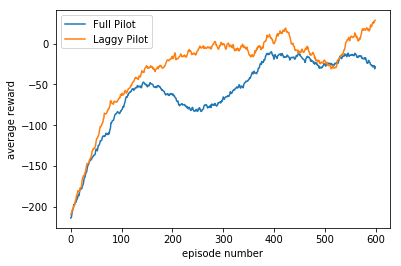

In [123]:
plt.plot(range(moving_avg(full['rewards'], 100).size), moving_avg(full['rewards'], 100), label='Full Pilot')
plt.plot(range(moving_avg(laggy['rewards'], 100).size), moving_avg(laggy['rewards'], 100), label='Laggy Pilot')
plt.ylabel('average reward')
plt.xlabel('episode number')
plt.legend()
plt.show()

Interestingly enough the Laggy pilot outperforms the full pilot when accompanied by the copilot and only taking in to account reward. The full pilot's expected reward has actually decreased. With regards to the application space, this implies that this approach to shared autonomy may only be beneficial to non-expert users.

### Rolling average outcomes

In [124]:
full['success'] = make_nan_outcome_mat(reward_logs[full_pilot_key]['outcomes'], 100, max_ep_len=699)
full['crash'] = make_nan_outcome_mat(reward_logs[full_pilot_key]['outcomes'], -100, max_ep_len=699)
laggy['success'] = make_nan_outcome_mat(reward_logs[laggy_pilot_key]['outcomes'], 100, max_ep_len=699)
laggy['crash'] = make_nan_outcome_mat(reward_logs[laggy_pilot_key]['outcomes'], -100, max_ep_len=699)

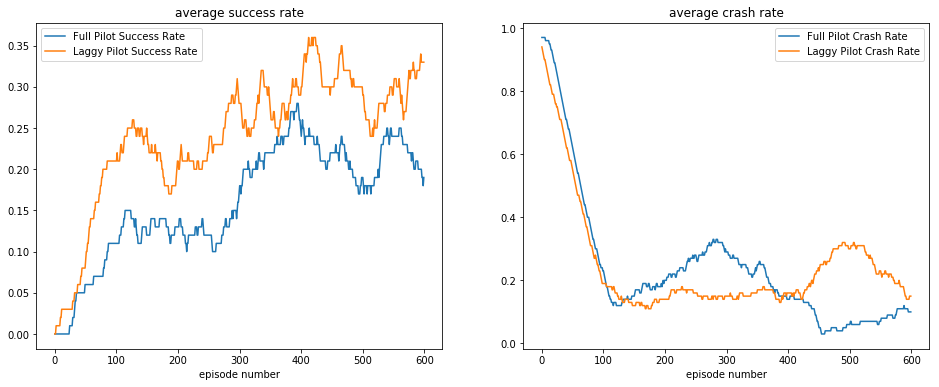

In [125]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.plot(range(moving_avg(full['success'], 100).size), moving_avg(full['success'], 100), label='Full Pilot Success Rate')
ax2.plot(range(moving_avg(full['crash'], 100).size), moving_avg(full['crash'], 100), label='Full Pilot Crash Rate')
ax1.plot(range(moving_avg(laggy['success'], 100).size), moving_avg(laggy['success'], 100), label='Laggy Pilot Success Rate')
ax2.plot(range(moving_avg(laggy['crash'], 100).size), moving_avg(laggy['crash'], 100), label='Laggy Pilot Crash Rate')
ax1.set_title('average success rate')
ax2.set_title('average crash rate')
ax1.set_xlabel('episode number')
ax2.set_xlabel('episode number')
ax1.legend()
ax2.legend()
plt.show()

### Compare against solo simulated pilots

In [133]:
pilot_names = ['full', 'laggy']
n_eval_eps = 1000
pilot_evals = [list(zip(*[run_ep(eval('%s_pilot_policy' % pilot_name),
                                 env,
                                 max_ep_len,
                                 render=False
                                ) for _ in range(n_eval_eps)])) for pilot_name in pilot_names]

# save evaluation data
pe_outfile = open(os.path.join(data_dir, 'pilot_evals.pkl'), 'wb')
pickle.dump(dict(zip(pilot_names, pilot_evals)), pe_outfile, pickle.HIGHEST_PROTOCOL)
pe_outfile.close()

mean_rewards = [np.mean(pilot_eval[0]) for pilot_eval in pilot_evals]

print('\n'.join([str(x) for x in zip(pilot_names, mean_rewards)]))

('full', 159.16665007579118)
('laggy', -21.832312444151455)


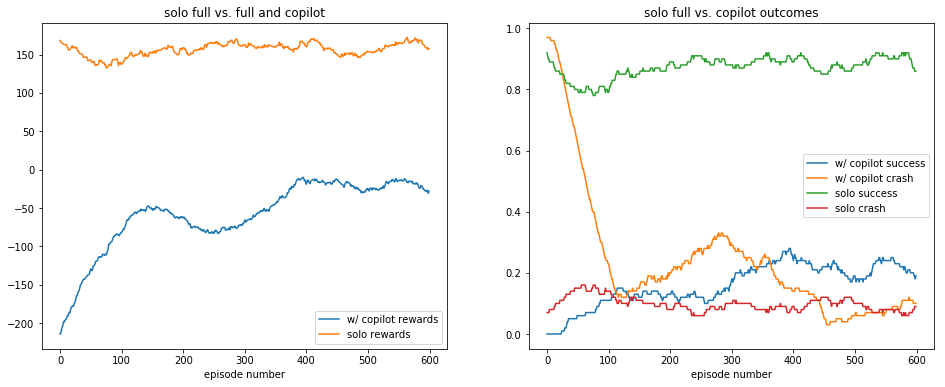

In [143]:
full_no_copilot = {}

full_no_copilot['rewards'] = make_nan_rew_mat([np.asarray(pilot_evals[0][0])], max_ep_len=699)
full_no_copilot['success'] = make_nan_outcome_mat([np.asarray(pilot_evals[0][1])], 100, max_ep_len=699)
full_no_copilot['crash'] = make_nan_outcome_mat([np.asarray(pilot_evals[0][1])], -100, max_ep_len=699)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.plot(range(moving_avg(full['rewards'], 100).size), moving_avg(full['rewards'], 100), label='w/ copilot rewards')
ax1.plot(range(moving_avg(full_no_copilot['rewards'], 100).size), moving_avg(full_no_copilot['rewards'], 100), label='solo rewards')
ax1.set_title('solo full vs. copilot rewards')
ax1.set_xlabel('episode number')
ax1.legend()

ax2.plot(range(moving_avg(full['success'], 100).size), moving_avg(full['success'], 100), label='w/ copilot success')
ax2.plot(range(moving_avg(full['crash'], 100).size), moving_avg(full['crash'], 100), label='w/ copilot crash')
ax2.plot(range(moving_avg(full_no_copilot['success'], 100).size), moving_avg(full_no_copilot['success'], 100), label='solo success')
ax2.plot(range(moving_avg(full_no_copilot['crash'], 100).size), moving_avg(full_no_copilot['crash'], 100), label='solo crash')
ax2.set_title('solo full vs. copilot outcomes')
ax2.set_xlabel('episode number')
ax2.legend()

plt.show()

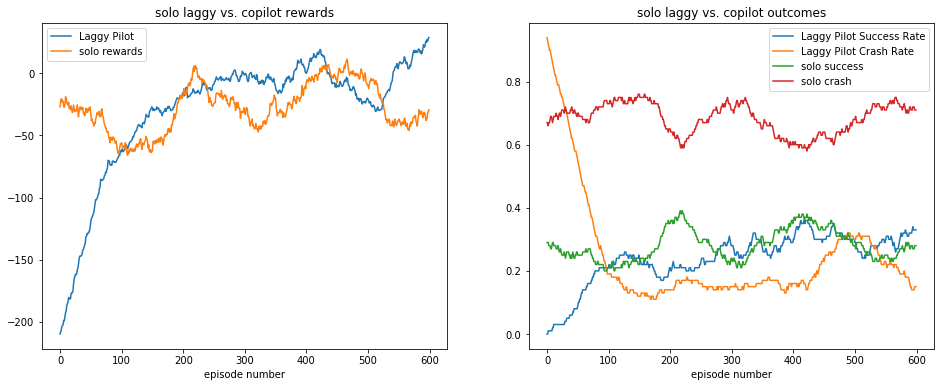

In [144]:
laggy_no_copilot = {}

laggy_no_copilot['rewards'] = make_nan_rew_mat([np.asarray(pilot_evals[1][0])], max_ep_len=699)
laggy_no_copilot['success'] = make_nan_outcome_mat([np.asarray(pilot_evals[1][1])], 100, max_ep_len=699)
laggy_no_copilot['crash'] = make_nan_outcome_mat([np.asarray(pilot_evals[1][1])], -100, max_ep_len=699)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.plot(range(moving_avg(laggy['rewards'], 100).size), moving_avg(laggy['rewards'], 100), label='Laggy Pilot')
ax1.plot(range(moving_avg(laggy_no_copilot['rewards'], 100).size), moving_avg(laggy_no_copilot['rewards'], 100), label='solo rewards')
ax1.set_title('solo laggy vs. copilot rewards')
ax1.set_xlabel('episode number')
ax1.legend()

ax2.plot(range(moving_avg(laggy['success'], 100).size), moving_avg(laggy['success'], 100), label='Laggy Pilot Success Rate')
ax2.plot(range(moving_avg(laggy['crash'], 100).size), moving_avg(laggy['crash'], 100), label='Laggy Pilot Crash Rate')
ax2.plot(range(moving_avg(laggy_no_copilot['success'], 100).size), moving_avg(laggy_no_copilot['success'], 100), label='solo success')
ax2.plot(range(moving_avg(laggy_no_copilot['crash'], 100).size), moving_avg(laggy_no_copilot['crash'], 100), label='solo crash')
ax2.set_title('solo laggy vs. copilot outcomes')
ax2.set_xlabel('episode number')
ax2.legend()

plt.show()

## Future work
- Continue experiments to reach convergence
- Investigate effects of having $\alpha$ as a learned parameter

## Debug

In [135]:
# plt.plot(range(moving_avg(full_no_copilot['success'], 100).size), moving_avg(full_no_copilot['success'], 100), label='Success')
# plt.plot(range(moving_avg(full_no_copilot['crash'], 100).size), moving_avg(full_no_copilot['crash'], 100), label='Crash')
# plt.show()
# reward_logs[full_pilot_key]['rewards']
# [full_pilot_reward_data['rewards']
[np.asarray(pilot_evals[0][0])]

[array([ 179.54354583,  236.66574125,  206.69604848,   30.09949881,
         246.21700846,  -44.09208797,  238.9834612 ,  241.40310325,
         202.11828881,  141.91068598,  224.70451603,  210.76091889,
         206.22069735,  155.33912718,  175.25832101,  178.51096623,
         117.04110663,  104.05943871,   47.0747876 ,  164.5355647 ,
         175.47190658,   99.53501932,  236.0132569 ,  169.94700431,
         217.88967269,  166.169634  ,  190.05621099,  207.87310917,
         220.52157068,  176.76099229,  221.94015079,  184.5440974 ,
         207.18582418,  181.4136249 ,  231.50570394,  271.66995742,
         153.46248463,  219.1869106 ,   92.57951876,  188.84732981,
         197.44648673,  205.85838875,  209.64618721,  234.09519229,
         206.35722834,  180.33889094,  212.12891058,  210.2596296 ,
         194.42698693,  255.59860487,  190.37814316,  174.71895976,
         263.7555389 ,   44.97620447,  215.09513611,  221.81353689,
         195.77647064,  233.94328068,   76.75070

In [37]:
%whos

Variable                           Type                Data/Info
----------------------------------------------------------------
ActWrapper                         type                <class 'baselines.deepq.simple.ActWrapper'>
Counter                            type                <class 'collections.Counter'>
LaggyPilotPolicy                   type                <class '__main__.LaggyPilotPolicy'>
LinearSchedule                     type                <class 'baselines.common.<...>chedules.LinearSchedule'>
PrioritizedReplayBuffer            type                <class 'baselines.deepq.r<...>PrioritizedReplayBuffer'>
ReplayBuffer                       type                <class 'baselines.deepq.r<...>lay_buffer.ReplayBuffer'>
U                                  module              <module 'baselines.common<...>nes\\common\\tf_util.py'>
build_goal_decoder                 NoneType            None
co_build_act                       function            <function co_build_act at 0x00000000

uuid                               module              <module 'uuid' from 'c:\\<...>eepassist\\lib\\uuid.py'>
v                                  list                n=800
wrappers                           module              <module 'gym.wrappers' fr<...>\\wrappers\\__init__.py'>
zipfile                            module              <module 'zipfile' from 'c<...>assist\\lib\\zipfile.py'>
